In [ ]:
import os
import numpy as np
import matplotlib
import torch
# !pip install mat73
# import mat73
import matplotlib.pyplot as plt
import csv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split,TensorDataset
from torchvision import transforms, utils
import time
import pandas as pd
import scipy.io
import sklearn.metrics
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

from scipy import signal

from sklearn.metrics import confusion_matrix

import seaborn as sn
import pandas as pd

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import LeaveOneGroupOut






In [ ]:
from math import sqrt
import torch
import torch.nn.functional as F
from torch import nn
!pip install einops
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class LSA(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.temperature = nn.Parameter(torch.log(torch.tensor(dim_head ** -0.5)))

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.temperature.exp()

        mask = torch.eye(dots.shape[-1], device = dots.device, dtype = torch.bool)
        mask_value = -torch.finfo(dots.dtype).max
        dots = dots.masked_fill(mask, mask_value)

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, LSA(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class SPT(nn.Module):
    def __init__(self, *, dim, patch_size, channels = 3):
        super().__init__()
        patch_dim = patch_size * patch_size * 5 * channels

        self.to_patch_tokens = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim)
        )

    def forward(self, x):
        shifts = ((1, -1, 0, 0), (-1, 1, 0, 0), (0, 0, 1, -1), (0, 0, -1, 1))
        shifted_x = list(map(lambda shift: F.pad(x, shift), shifts))
        x_with_shifts = torch.cat((x, *shifted_x), dim = 1)
        return self.to_patch_tokens(x_with_shifts)

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = SPT(dim = dim, patch_size = patch_size, channels = channels)

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

FiltName='filt_0.1_5'
file_name_data=r"/content/drive/My Drive/Colab Notebooks/RFMG/data/data_all_per8_multi6_"+FiltName+".npz"
data=np.load(file_name_data)

feature_cwt_per=data['feature_cwt_per']
feature_stft2_per=data['feature_stft2_per']


# feature_cwt2_per=data['feature_cwt2_per']
# feature_cwt3_per=data['feature_cwt3_per']

label_all_per=data['label_all_per']
caseNum_all_per=data['caseNum_all_per']
perNum_all_per=data['perNum_all_per']

data=[]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
(unique, counts) = np.unique(perNum_all_per, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[  1. 645.]
 [  2. 809.]
 [  3. 851.]
 [  4. 794.]
 [  5. 692.]
 [  6. 688.]
 [  7. 684.]
 [  8. 684.]]


[[  2. 809.]
 [  3. 851.]
 [  4. 794.]
 [  5. 692.]
 [  6. 688.]
 [  7. 684.]
 [  8. 692.]
 [  9. 684.]]
[[  1. 645.]]
0.13387633563301546
0.1469752596330273
0.04577679031069982
0.13142140087231186
0.026142604406360532
0.12785128602223803
0.01725778410297796
0.1306186799162118
0.01261275051863852
0.14323631559693537
0.009519494532107861
0.14583319698193276
0.0071575283738119265
0.15164976245904155
0.005135560653153156
0.15321900993585585


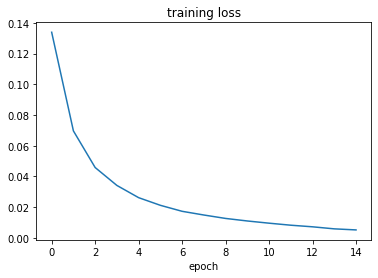

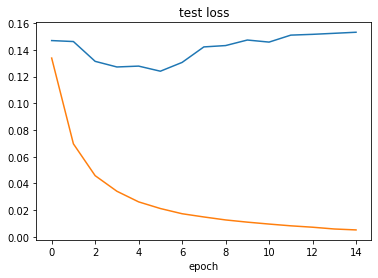

[[53  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0  2  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  6 23  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 23  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 20  1  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0 22  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  3  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  6  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 10  0 14  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  4  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  4 20  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 21  3  0  0  0  0  0  0

In [ ]:
in_ch=48
num_class=23
self_channel=[0,1,10,11,20,21,30,31]
par_vit={'dim':512,'depth':6,'heads':16,'mlp_dim':32,'dropout':0.1,'emb_dropout':0.1,'n_epoch':15,'learning_rate':1e-5};



def gen_trans_model(X_all,y_all,opt,per_test,FeatType):
  import torch
  torch.cuda.empty_cache()

  if __name__ == '__main__':
      
      transform = ToTensor()
      batchsize_train = 16

      # folds=RepeatedStratifiedKFold(n_splits=5, n_repeats=1,random_state=100).split(X_all,y_all)
      # folds=StratifiedGroupKFold(n_splits=7).split(X_all,y_all,perNum_all_per) 
      # test_ind_all=[]
      # train_ind_all=[]
      # for train_index, test_index in folds:
      #   test_ind_all.append(test_index)
      #   train_ind_all.append(train_index)
      # n_sel=2
      
      tst_ind=np.where(perNum_all_per==per_test)[0]
      trn_ind=np.where(perNum_all_per!=per_test)[0]

      X_train=X_all[trn_ind] 
      X_test=X_all[tst_ind]
      y_train=y_all[trn_ind] 
      y_test=y_all[tst_ind]

      train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)), batch_size=batchsize_train,shuffle=True)
      batchsize_test = 16
      test_loader = DataLoader(TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test)), batch_size=batchsize_test, shuffle=False)


      (unique, counts) = np.unique(perNum_all_per[trn_ind], return_counts=True)
      frequencies = np.asarray((unique, counts)).T
      print(frequencies)
      (unique, counts) = np.unique(perNum_all_per[tst_ind], return_counts=True)
      frequencies = np.asarray((unique, counts)).T
      print(frequencies)
      #hyperparameter definition    
      learning_rate = par_vit['learning_rate']  #学习的速率 越小越精细
      momentum = 0.1
      random_seed=1
      torch.backends.cudnn.enabled = False
      torch.manual_seed(random_seed)     #设定随机数种子为固定值
      
      train_loss_epoch = []
      test_acc_epoch =[]
      total_acc_epoch = []
      

   

      network = ViT(
      image_size = opt['image_size'],
      patch_size = opt['patch_size'],
      num_classes =num_class,
      dim = par_vit['dim'],
      depth = par_vit['depth'],
      heads = par_vit['heads'],
      mlp_dim = par_vit['mlp_dim'],
      dropout = par_vit['dropout'],
      emb_dropout = par_vit['emb_dropout'],
      channels = in_ch
      ).cuda()
   
      #training
      optimizer = optim.Adam(network.parameters(), lr=learning_rate)
      #optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)
      

      #network.train()
      Training_Loss = []
      Test_Loss = []
      start_time = time.time()
      criterion = nn.CrossEntropyLoss()
      #criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1, 3]).cuda())
      for epoch in range(par_vit['n_epoch']):   # loop over the dataset multiple times
          train_loss = 0
          for X, Y in train_loader:
              # X = X.view(-1,1,X.shape[2],X.shape[3]).cuda()
              X = X.float().cuda()  
              Y = Y.long().view(-1, ).cuda() 
              current_batchsize = X.shape[0]
              optimizer.zero_grad()
              output = network(X)
              loss = criterion(output,Y)
              train_loss = train_loss + loss.item()
              loss.backward()                     #calculate the gradient decent
              optimizer.step()                    #update the weight
              
            





          test_loss = 0
          correct = 0
          total = 0
          test_y= []
          test_y_p = []
     
          with torch.no_grad():        
              # X = X.view(-1,X.shape[1],X.shape[2])
              # X = X.float()         
              for X, Y in test_loader:
                  X = torch.Tensor(X).cuda()
                  Y = torch.Tensor(Y).long().view(-1, ).cuda()
                  images, labels = X, Y
                  # calculate outputs by running images through the network
                  outputs = network(images)
                  loss = criterion(outputs,Y)
                  test_loss = test_loss + loss.item()

                  # the class with the highest energy is what we choose as prediction
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()
                  
                  for i in range(len(labels)):
                    test_y.append(labels[i])
                    test_y_p.append(predicted[i])
          
          #print('Accuracy of test cases: %d %%' % (100 * correct / total))
  

          Training_Loss.append(train_loss/len(train_loader.dataset))
          Test_Loss.append(test_loss/len(test_loader.dataset))
          if epoch%2==0:
              print(train_loss/len(train_loader.dataset))
              print(test_loss/len(test_loader.dataset))
        
      FeatName=['stft','stft2','cwt','cwt2','cwt3']        
      PATH='/content/drive/My Drive/Colab Notebooks/RFMG/data/'+"/model_all/"+FeatName[FeatType]+"_ex_"+str(per_test)+".pt"
      torch.save(network.state_dict(), PATH)
      # train_loss_epoch.append(Training_Loss[-1])
      # training_time=time.time()-start_time
      #print('total training time is',training_time)
      
      plt.figure()
      plt.plot(Training_Loss)
      plt.title("training loss")
      plt.xlabel("epoch")
      plt.show()

      plt.figure()
      plt.plot(Test_Loss)
      plt.title("test loss")
      plt.xlabel("epoch")
      plt.plot(Training_Loss)
      plt.show()

  test_y_p=torch.FloatTensor(test_y_p)
  test_y=torch.FloatTensor(test_y)
  test_y_p=np.array(test_y_p.cpu())
  test_y=np.array(test_y.cpu())
  test_y2=np.stack((test_y, test_y_p))



  cm=confusion_matrix(test_y, test_y_p)
  acc=accuracy_score(test_y, test_y_p)
  print(cm,acc)
  return cm,acc,test_y2

#cm,acc,test_y2=test(feature_2d_stft,label_all,{'net':'stft'})
#cm,acc,test_y2=test(feature_all,label_all,{'net':'1d'})
# cm1,acc1,test_y1=test(feature_2d_stft[:,:32,:,:],label_all,{'net':'stft'})

# ind=np.where(perNum_all_per==6)[0]
cm1=[]
acc1=[]
test_y1=[]
cm2=[]
acc2=[]
test_y2=[]
for i in range(1,int(np.max(perNum_all_per))+1):


  cm,acc,test_y=gen_trans_model(feature_cwt_per,label_all_per,{'image_size':125,'patch_size':5},i,2)
  cm1.append(cm)
  acc1.append(acc)
  test_y1.append(test_y)
for i in range(1,int(np.max(perNum_all_per))+1):
  cm,acc,test_y=gen_trans_model(feature_cwt3_per,label_all_per,{'image_size':40,'patch_size':5},i,1)
  cm2.append(cm)
  acc2.append(acc)
  test_y2.append(test_y)


parameter_vit=np.array(list(par_vit.items()));
np.savez_compressed("/content/drive/My Drive/Colab Notebooks/RFMG/data/model_all/npyFile/vit_cwt_stft2_gen_trans_model.npz",\
                  cm1=cm1,acc1=acc1,test_y1=test_y1,\
                  cm2=cm2,acc2=acc2,test_y2=test_y2,\
                  parameter_vit=parameter_vit)

In [ ]:
def Load_TransModel(Name,model):


  dataPath="/content/drive/My Drive/Colab Notebooks/RFMG/data/"
  PATH=dataPath+"/model_all/"+Name+".pt"
  model_trans = vit_trans
  model_trans.load_state_dict(torch.load(PATH))
  model_trans.eval()

  # for param in model_trans.parameters():
  #     param.requires_grad = False

  # model_trans.fc1 = nn.Linear(model_trans.fc1.in_features, model_trans.fc2.in_features)
  # model_trans.fc2 = nn.Linear(model_trans.fc2.in_features, num_class)
  return model_trans

vit_trans=ViT(
        image_size =125,
        patch_size = 5,
        num_classes =num_class,
        dim = par_vit['dim'],
        depth = par_vit['depth'],
        heads = par_vit['heads'],
        mlp_dim = par_vit['mlp_dim'],
        dropout = par_vit['dropout'],
        emb_dropout = par_vit['emb_dropout'],
        channels = in_ch
        ).cuda()



[[  1. 645.]]
[[ 1. 16.]
 [ 2. 13.]
 [ 3. 21.]
 [ 4. 18.]
 [ 5. 15.]
 [ 6. 23.]
 [ 7. 17.]
 [ 8. 17.]
 [ 9. 18.]
 [10. 23.]
 [11. 16.]
 [12. 18.]]
[[ 1. 37.]
 [ 2. 40.]
 [ 3. 32.]
 [ 4. 35.]
 [ 5. 37.]
 [ 6. 30.]
 [ 7. 36.]
 [ 8. 36.]
 [ 9. 37.]
 [10. 33.]
 [11. 39.]
 [12. 38.]]
0.13309368477311245
0.07832848892308945
0.025613175124623053
0.036570413159423096
0.009735052651444146
0.024417424245282662
0.005272892143490702
0.022156033500335938
0.0035660935782415924
0.019788290265687677
0.0026423335205330405
0.018794589251453102
0.0021580225939667502
0.0178880154913248
0.001680509226266728
0.017073755152523518
0.0014736829368874084
0.016471080681265786
0.0012346876178716505
0.01616811823792929


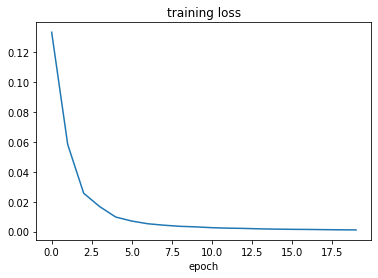

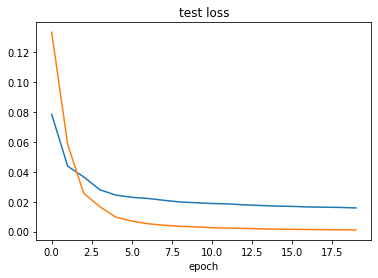

[[35  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 15  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 15  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 15  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 15  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 12  0  0  0  1  3  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0

KeyboardInterrupt: ignored

In [ ]:
in_ch=48
num_class=23
self_channel=[0,1,10,11,20,21,30,31]
par_vit={'dim':512,'depth':6,'heads':16,'mlp_dim':32,'dropout':0.1,'emb_dropout':0.1};

# folds=StratifiedGroupKFold(n_splits=9).split(feature_cwt2_per,label_all_per,perNum_all_per)

# for train_index, test_index in folds:
#     test_ind_all.append(test_index)
#     train_ind_all.append(train_index)
# n_sel=2

def test_trans(X_all,y_all,opt,trans_net):
  import torch
  torch.cuda.empty_cache()

  if __name__ == '__main__':
      
      transform = ToTensor()
      batchsize_train = 16

      folds=RepeatedStratifiedKFold(n_splits=3, n_repeats=1,random_state=100).split(X_all,y_all)

      test_ind_all=[]
      train_ind_all=[]
      for train_index, test_index in folds:
        test_ind_all.append(test_index)
        train_ind_all.append(train_index)
      n_sel=2

      # train_ind=train_ind_all[n_sel]
      # test_ind=test_ind_all[n_sel]

   
      train_ind=test_ind_all[n_sel]
      test_ind=train_ind_all[n_sel]


      X_train=X_all[train_ind] 
      X_test=X_all[test_ind]
      y_train=y_all[train_ind] 
      y_test=y_all[test_ind]

      train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)), batch_size=batchsize_train,shuffle=True)
      batchsize_test = 16
      test_loader = DataLoader(TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test)), batch_size=batchsize_test, shuffle=False)


      (unique, counts) = np.unique(perNum_all_per[ind], return_counts=True)
      frequencies = np.asarray((unique, counts)).T
      print(frequencies)

      (unique, counts) = np.unique(caseNum_all_per[ind][train_ind], return_counts=True)
      frequencies = np.asarray((unique, counts)).T
      print(frequencies)
      (unique, counts) = np.unique(caseNum_all_per[ind][test_ind], return_counts=True)
      frequencies = np.asarray((unique, counts)).T
      print(frequencies)
      #hyperparameter definition    
      learning_rate = 1e-5  #学习的速率 越小越精细
      momentum = 0.1
      random_seed=1
      torch.backends.cudnn.enabled = False
      torch.manual_seed(random_seed)     #设定随机数种子为固定值
      
      train_loss_epoch = []
      test_acc_epoch =[]
      total_acc_epoch = []
      #epoch_range = np.arange(25,225,25)
      epoch_range = np.array([2])

   
      if  opt['trans']==0:
        network = ViT(
        image_size = opt['image_size'],
        patch_size = opt['patch_size'],
        num_classes =num_class,
        dim = par_vit['dim'],
        depth = par_vit['depth'],
        heads = par_vit['heads'],
        mlp_dim = par_vit['mlp_dim'],
        dropout = par_vit['dropout'],
        emb_dropout = par_vit['emb_dropout'],
        channels = in_ch
        ).cuda()
      if opt['trans']==1:
        network =trans_net.cuda()
      #training
      optimizer = optim.Adam(network.parameters(), lr=learning_rate)
      #optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)
      

      #network.train()
      Training_Loss = []
      Test_Loss = []
      start_time = time.time()
      criterion = nn.CrossEntropyLoss()
      #criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1, 3]).cuda())
      for epoch in range(20):   # loop over the dataset multiple times
          train_loss = 0
          for X, Y in train_loader:
              # X = X.view(-1,1,X.shape[2],X.shape[3]).cuda()
              X = X.float().cuda()  
              Y = Y.long().view(-1, ).cuda() 
              current_batchsize = X.shape[0]
              optimizer.zero_grad()
              output = network(X)
              loss = criterion(output,Y)
              train_loss = train_loss + loss.item()
              loss.backward()                     #calculate the gradient decent
              optimizer.step()                    #update the weight
              
            





          test_loss = 0
          correct = 0
          total = 0
          test_y= []
          test_y_p = []
     
          with torch.no_grad():        
              # X = X.view(-1,X.shape[1],X.shape[2])
              # X = X.float()         
              for X, Y in test_loader:
                  X = torch.Tensor(X).cuda()
                  Y = torch.Tensor(Y).long().view(-1, ).cuda()
                  images, labels = X, Y
                  # calculate outputs by running images through the network
                  outputs = network(images)
                  loss = criterion(outputs,Y)
                  test_loss = test_loss + loss.item()

                  # the class with the highest energy is what we choose as prediction
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()
                  
                  for i in range(len(labels)):
                    test_y.append(labels[i])
                    test_y_p.append(predicted[i])
          
          #print('Accuracy of test cases: %d %%' % (100 * correct / total))
  

          Training_Loss.append(train_loss/len(train_loader.dataset))
          Test_Loss.append(test_loss/len(test_loader.dataset))
          if epoch%2==0:
              print(train_loss/len(train_loader.dataset))
              print(test_loss/len(test_loader.dataset))
        
              
      # PATH='/content/drive/My Drive/Colab Notebooks/RFMG/data/'+"/model_all/"+"cwt2_ex_8.pt"
      # torch.save(network.state_dict(), PATH)
      # train_loss_epoch.append(Training_Loss[-1])
      # training_time=time.time()-start_time
      #print('total training time is',training_time)
      
      plt.figure()
      plt.plot(Training_Loss)
      plt.title("training loss")
      plt.xlabel("epoch")
      plt.show()

      plt.figure()
      plt.plot(Test_Loss)
      plt.title("test loss")
      plt.xlabel("epoch")
      plt.plot(Training_Loss)
      plt.show()

  test_y_p=torch.FloatTensor(test_y_p)
  test_y=torch.FloatTensor(test_y)
  test_y_p=np.array(test_y_p.cpu())
  test_y=np.array(test_y.cpu())
  test_y2=np.stack((test_y, test_y_p))



  cm=confusion_matrix(test_y, test_y_p)
  acc=accuracy_score(test_y, test_y_p)
  print(cm,acc)
  return cm,acc,test_y2

#cm,acc,test_y2=test(feature_2d_stft,label_all,{'net':'stft'})
#cm,acc,test_y2=test(feature_all,label_all,{'net':'1d'})
# cm1,acc1,test_y1=test(feature_2d_stft[:,:32,:,:],label_all,{'net':'stft'})

ind=np.where(perNum_all_per==1)[0]
cwt2_trans_1=Load_TransModel('cwt2_ex_1',vit_trans) 
cm2,acc2,test_y2=test_trans(feature_cwt2_per[ind,:,:,:],label_all_per[ind],{'image_size':125,'patch_size':5,'trans':1},cwt2_trans_1)

cm2,acc2,test_y2=test_trans(feature_cwt2_per[ind,:,:,:],label_all_per[ind],{'image_size':125,'patch_size':5,'trans':0},cwt2_trans_1)

# cm3,acc3,test_y3=test(feature_2d_stft3[:,:32,:,:],label_all,{'net':'stft3'})
# cm4,acc4,test_y4=test(feature_2d_cwt[:,:32,:,:],label_all,{'net':'cwt'})
# cm5,acc5,test_y5=test(feature_2d_cwt2[:,:32,:,:],label_all,{'net':'cwt2'})
# cm5,acc5,test_y5=test(feature_2d_cwt3[:,:32,:,:],label_all,{'net':'cwt'})

In [ ]:
ind=np.where(perNum_all_per==6)[0]

In [ ]:

y_ensemble=np.zeros([np.size(test_y1,axis=1),])
for i in range(np.size(test_y1,axis=1)):
  
  list=[test_y1[1,i],test_y2[1,i],test_y4[1,i],test_y5[1,i],test_y6[1,i]]
  
  (unique, counts) = np.unique(list, return_counts=True)

  label=unique[np.argmax(counts)]
  y_ensemble[i]=label

cm_norm=confusion_matrix(test_y1[0,:], y_ensemble,normalize='true')
cm=confusion_matrix(test_y1[0,:], y_ensemble)
acc=accuracy_score(test_y1[0,:], y_ensemble)

print(acc,cm)

0.8932038834951457 [[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  5  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  4  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  5  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  1  0  0]
 [ 0  0  0  0  0  0  

In [ ]:
# load different participants' data into one big dataset 
# add person number ID


from google.colab import drive
drive.mount('/content/drive')

FiltName='filt_0.1_5'
def loadExp(ExpVer_temp,perNum):
  file_name_data=r"/content/drive/My Drive/Colab Notebooks/RFMG/data/"+ExpVer_temp+"/data_all_multi6_"+FiltName+".npz"
  data=np.load(file_name_data)
  feature_all=data['feature_all']
  feature_2d_stft=data['feature_2d_stft']
  feature_2d_stft2=data['feature_2d_stft2']
  feature_2d_cwt=data['feature_2d_cwt']
  feature_2d_cwt2=data['feature_2d_cwt2']
  feature_2d_cwt3=data['feature_2d_cwt3']

  feature_all6=[feature_2d_stft,feature_2d_stft2[:,:,:40,:40],feature_2d_cwt,feature_2d_cwt2,feature_2d_cwt3,feature_all]

  
  label_all=data['label_all']
  caseNum_all=data['caseNum_all']

  perNum_all=np.ones((len(label_all), ))*perNum
  return feature_all6,label_all,caseNum_all,perNum_all

feature_all6_per=[]  # list : item: sample cases in total,  [stft, stft2, cwt, cwt2, cwt3, 1d] *feature: case num * channel num * time * freq    
feature_stft_per=[]
feature_stft2_per=[]
feature_cwt_per=[]
feature_cwt2_per=[]
feature_cwt3_per=[]
feature_1d_per=[]

label_all_per=[]
caseNum_all_per=[]
perNum_all_per=[]
#ExpVer_list=['2_5','2_9','2_10','2_11','2_13','2_14','2_15','2_17']
ExpVer_list=['2_5','2_9','2_10','2_11','2_13','2_14','2_15','2_16','2_17']
for j in range(len(ExpVer_list)):
  feature_all6,label_all,caseNum_all,perNum_all=loadExp(ExpVer_list[j],j+1)

  # loop to append each sample in every person
  for i in range(len(label_all)):
  
    feature_stft_per.append(feature_all6[0][i,:,:,:])
    feature_stft2_per.append(feature_all6[1][i,:,:,:])
    feature_cwt_per.append(feature_all6[2][i,:,:,:])
    feature_cwt2_per.append(feature_all6[3][i,:,:,:])
    feature_cwt3_per.append(feature_all6[4][i,:,:,:])
    feature_1d_per.append(feature_all6[5][i,:,:])

    label_all_per.append(label_all[i])
    caseNum_all_per.append(caseNum_all[i])
    perNum_all_per.append(perNum_all[i])

feature_stft_per=np.array(feature_stft_per).astype('float16')
feature_stft2_per=np.array(feature_stft2_per).astype('float16')
feature_cwt_per=np.array(feature_cwt_per).astype('float16')
feature_cwt2_per=np.array(feature_cwt2_per).astype('float16')
feature_cwt3_per=np.array(feature_cwt3_per).astype('float16')
feature_1d_per=np.array(feature_1d_per).astype('float16')

label_all_per=np.array(label_all_per)
caseNum_all_per=np.array(caseNum_all_per)
perNum_all_per=np.array(perNum_all_per)
#feature_all6_per=[feature_stft_per,feature_stft2_per,feature_cwt_per,feature_cwt2_per,feature_cwt3_per,feature_1d_per]

np.savez_compressed("/content/drive/My Drive/Colab Notebooks/RFMG/data/data_all_per9_multi6_"+FiltName+".npz",feature_1d_per=feature_1d_per,\
                    feature_stft_per=feature_stft_per,feature_stft2_per=feature_stft2_per,\
                    feature_cwt_per=feature_cwt_per,feature_cwt2_per=feature_cwt2_per,feature_cwt3_per=feature_cwt3_per,\
                    label_all_per=label_all_per,caseNum_all_per=caseNum_all_per,perNum_all_per=perNum_all_per)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
feature_stft_per=np.array(feature_stft_per).astype('float16')
feature_stft2_per=np.array(feature_stft2_per).astype('float16')
feature_cwt_per=np.array(feature_cwt_per).astype('float16')
feature_cwt2_per=np.array(feature_cwt2_per).astype('float16')
feature_cwt3_per=np.array(feature_cwt3_per).astype('float16')
feature_1d_per=np.array(feature_1d_per).astype('float16')

label_all_per=np.array(label_all_per)
caseNum_all_per=np.array(caseNum_all_per)
perNum_all_per=np.array(perNum_all_per)
#feature_all6_per=[feature_stft_per,feature_stft2_per,feature_cwt_per,feature_cwt2_per,feature_cwt3_per,feature_1d_per]

np.savez_compressed("/content/drive/My Drive/Colab Notebooks/RFMG/data/data_all_per9_multi6_"+FiltName+".npz",feature_1d_per=feature_1d_per,\
                    feature_stft_per=feature_stft_per,feature_stft2_per=feature_stft2_per,\
                    feature_cwt_per=feature_cwt_per,feature_cwt2_per=feature_cwt2_per,feature_cwt3_per=feature_cwt3_per,\
                    label_all_per=label_all_per,caseNum_all_per=caseNum_all_per,perNum_all_per=perNum_all_per)

In [ ]:
## delete some participant's data
from google.colab import drive
drive.mount('/content/drive')

FiltName='filt_0.1_5'
file_name_data=r"/content/drive/My Drive/Colab Notebooks/RFMG/data/data_all_per_multi6_"+FiltName+".npz"
data=np.load(file_name_data)

feature_cwt_per=data['feature_cwt_per']
feature_stft2_per=data['feature_stft2_per']
feature_stft_per=data['feature_stft_per']

feature_cwt2_per=data['feature_cwt2_per']
feature_cwt3_per=data['feature_cwt3_per']
feature_1d_per=data['feature_1d_per']
label_all_per=data['label_all_per']
caseNum_all_per=data['caseNum_all_per']
perNum_all_per=data['perNum_all_per']

del_per=np.where(perNum_all_per==8)[0]

feature_cwt_per=np.delete(feature_cwt_per,del_per,axis=0)
feature_cwt2_per=np.delete(feature_cwt2_per,del_per,axis=0)
feature_cwt3_per=np.delete(feature_cwt_per,del_per,axis=0)
feature_stft_per=np.delete(feature_stft_per,del_per,axis=0)
feature_stft2_per=np.delete(feature_stft2_per,del_per,axis=0)
feature_1d_per=np.delete(feature_1d_per,del_per,axis=0)

label_all_per=np.delete(label_all_per,del_per,axis=0)
caseNum_all_per=np.delete(caseNum_all_per,del_per,axis=0)
perNum_all_per=np.delete(perNum_all_per,del_per,axis=0)


Mounted at /content/drive


IndexError: ignored

In [ ]:
FiltName='filt_0.1_5'
file_name_data=r"/content/drive/My Drive/Colab Notebooks/RFMG/data/data_all_per_multi6_"+FiltName+".npz"
data=np.load(file_name_data)

feature_cwt2_per=data['feature_cwt2_per']


label_all_per=data['label_all_per']
caseNum_all_per=data['caseNum_all_per']
perNum_all_per=data['perNum_all_per']

data=[]

In [ ]:
# in_ch: CNN input channel number 
# num_class: classification number  8,5,3 
# opt CV method. groupKfold: kfold, all cases not been seen in training set  
# Kfold : randomly kfold. label and cases equally distributed
# group: leave one case out 

par_vit={'dim':512,'depth':6,'heads':16,'mlp_dim':64,'dropout':0.1,'emb_dropout':0.1,\
         'n_epoch':25,'learning_rate':1e-4};    
parameter_vit=np.array(list(par_vit.items()));
def kFCV(X_all,y_all,in_ch,num_class,opt,case,del_case):


   
   
    cm_all=[]
    acc_all=[]
    y_test_all=[]
    y_p_all=[]
    test_ind_all=[]
    
    case=case.flatten()
    idx=[]
    if del_case:
       for i in del_case:
           temp=np.where(caseNum_all==i)[0]
    
           for i in range(len(temp)):
             idx.append(temp[i])
 
       idx=np.array(idx).flatten()
     
       case=np.delete(case,idx)
       y_all=np.delete(y_all,idx)
       X_all=np.delete(X_all,idx,axis=0)

    if opt['method']=='groupKfold':
        folds=StratifiedGroupKFold(n_splits=k).split(X_all,y_all,case)
    if opt['method']=='Kfold':
        folds=RepeatedStratifiedKFold(n_splits=k, n_repeats=n_re,random_state=0).split(X_all,y_all)
    if opt['method']=='group':  
        logo = LeaveOneGroupOut()
        logo.get_n_splits(X_all,y_all,case)
        logo.get_n_splits(groups=case) 
        folds=logo.split(X_all,y_all,case)

    for train_ind, test_ind in folds:
           
       
        X_train=X_all[train_ind] 
        X_test=X_all[test_ind]
        y_train=y_all[train_ind] 
        y_test=y_all[test_ind]
        #print(train_ind,test_ind)
        

        for i in range(len(test_ind)):
            test_ind_all.append(test_ind[i])
           

        (unique, counts) = np.unique(case[test_ind], return_counts=True)
        frequencies = np.asarray((unique, counts)).T
        print(frequencies)

        batchsize_train = 16
        train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)), batch_size=batchsize_train,shuffle=True)
        batchsize_test = 16
        test_loader = DataLoader(TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test)), batch_size=batchsize_test, shuffle=False)
                
        
        n_epoch=par_vit['n_epoch']
        #n_epoch=25
        learning_rate = par_vit['learning_rate']  #学习的速率 越小越精细
        momentum = 0.1
        random_seed=1
        torch.backends.cudnn.enabled = False
        torch.manual_seed(random_seed)     #设定随机数种子为固定值
        
        train_loss_epoch = []
        test_acc_epoch =[]
        total_acc_epoch = []
        #epoch_range = np.arange(25,225,25)
        epoch_range = np.array([2])

        
        
        network = ViT(
        image_size = opt['image_size'],
        patch_size = opt['patch_size'],
        num_classes =num_class,
        dim = par_vit['dim'],
        depth = par_vit['depth'],
        heads = par_vit['heads'],
        mlp_dim = par_vit['mlp_dim'],
        dropout = par_vit['dropout'],
        emb_dropout = par_vit['emb_dropout'],
        channels = in_ch
        ).cuda()
        #training
        optimizer = optim.Adam(network.parameters(), lr=learning_rate)
        
        
        
        #network.train()
        Training_Loss = []
        Test_Loss = []
        start_time = time.time()
        criterion = nn.CrossEntropyLoss()
        for epoch in range(n_epoch):   # loop over the dataset multiple times
            train_loss = 0
            for X, Y in train_loader:
                
                X = X.float().cuda()  
                Y = Y.long().view(-1, ).cuda() 
                current_batchsize = X.shape[0]
                optimizer.zero_grad()
                output = network(X)
                loss = criterion(output,Y)
                train_loss = train_loss + loss.item()
                loss.backward()                     #calculate the gradient decent
                optimizer.step()                    #update the weight
                

            test_loss = 0
            correct = 0
            total = 0
            test_y= []
            test_y_p = []
            
            # sens = 0    # sensitivity = TP/(TP + FN)
            # prec = 0    # precision = TP/(TP + FP)
            with torch.no_grad():        
                # X = X.view(-1,X.shape[1],X.shape[2])
                # X = X.float()         
                for X, Y in test_loader:
                    X = torch.Tensor(X).cuda()
                    Y = torch.Tensor(Y).long().view(-1, ).cuda()
                    images, labels = X, Y
                    # calculate outputs by running images through the network
                    outputs = network(images)
                    loss = criterion(outputs,Y)
                    test_loss = test_loss + loss.item()

                    # the class with the highest energy is what we choose as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    
                    for i in range(len(labels)):
                      test_y.append(labels[i])
                      test_y_p.append(predicted[i])
                      

            Training_Loss.append(train_loss/len(train_loader.dataset))
            Test_Loss.append(test_loss/len(test_loader.dataset))
            # if epoch%(n_epoch-1)==0:
            #     print(train_loss/len(train_loader.dataset))
            #     print(test_loss/len(test_loader.dataset))
      
        train_loss_epoch.append(Training_Loss[-1])
        test_y_p=torch.FloatTensor(test_y_p)
        test_y=torch.FloatTensor(test_y)
     
        y_p=np.array(test_y_p.cpu())
        y=np.array(test_y.cpu())
        

        cm=confusion_matrix(y, y_p)
        acc=accuracy_score(y, y_p)
        
        cm_all.append(cm)
        acc_all.append(acc)
        for i in range(len(y_p)):
            y_p_all.append(y_p[i])
            y_test_all.append(y_test[i])
        print(acc) 


    acc_all=np.array(acc_all)
    cm_all=np.array(cm_all)
    y_test_all=np.array(y_test_all)
    y_p_all=np.array(y_p_all)
    y=np.stack((y_test_all, y_p_all))
    
    test_ind_all=np.array(test_ind_all)

    cm=confusion_matrix(y_test_all, y_p_all)
    cm_norm=confusion_matrix(y_test_all, y_p_all,normalize='true')

    acc=accuracy_score(y_test_all, y_p_all)
    


    print(acc) 
    print(cm)

    return cm_norm,cm,cm_all,acc,acc_all,y,test_ind_all

In [ ]:
m1='Kfold'
m2='groupKfold'
m3='group'
m=m2
a=0

opt1={'method':m,'image_size':56,'patch_size':7}
opt2={'method':m,'image_size':40,'patch_size':5}
opt3={'method':m,'image_size':125,'patch_size':5}

opt_list=[opt1,opt2,opt3,opt3,opt3]



In [ ]:
#feature_2d_del=stft_2d(feature_all_del)


self_channel=[0,1,10,11,20,21,30,31]
channel=np.linspace(0,31,32).astype(int) 
channel=np.linspace(0,47,48).astype(int) 
# channel=self_channel
in_ch=48
num_class=23
k=7
del_case=[]
n_re=1
cm=[]
cm_norm=[]
cm_all=[]
acc=[]
acc_all=[]
y=[]
test_ind_all=[]
feature_list=[feature_2d_stft,feature_2d_stft2[:,:,:40,:40],feature_2d_cwt,feature_2d_cwt2,feature_2d_cwt3]
feature_listName=["stft","stft2","cwt","cwt2","cwt3"]
if __name__ == '__main__':
  
    for i in range(5):
    
      cm_norm_temp,cm_temp,cm_all_temp,acc_temp,acc_all_temp,y_temp,test_ind_all_temp=kFCV(feature_list[i][:,channel,:,:],label_all,in_ch,num_class,opt=opt_list[i],case=caseNum_all,del_case=del_case)
      print(feature_list[i])
      cm_norm.append(cm_norm_temp)
      cm.append(cm_temp)
      cm_all.append(cm_all_temp)
      acc.append(acc_temp)
      acc_all.append(acc_all_temp)
      y.append(y_temp)
      test_ind_all.append(test_ind_all_temp)


y_en=np.zeros([np.size(y[0],axis=1),])
for i in range(np.size(y[0],axis=1)):
  
  y_pred_all=[y[0][1,i],y[1][1,i],y[2][1,i],y[3][1,i],y[4][1,i]]
  (unique, counts) = np.unique(y_pred_all, return_counts=True)

  label=unique[np.argmax(counts)]
  y_en[i]=label
cm_en=confusion_matrix(y[0][0,:], y_en)
acc_en=accuracy_score(y[0][0,:], y_en)
cm_norm_en=confusion_matrix(y[0][0,:], y_en,normalize='true')

y_max=y[np.argmax(acc)]
acc_max=acc[np.argmax(acc)]
cm_max=cm[np.argmax(acc)]
cm_norm_max=cm_norm[np.argmax(acc)]


SaveName='ch48_'+str(k)+m
print(acc,cm)
np.savez_compressed("/content/drive/My Drive/Colab Notebooks/RFMG/data/"+ExpVer+"/result/npyFile/vit_"+SaveName+"_ensemble5.npz",\
                    cm_norm=cm_norm,cm=cm,cm_all=cm_all,acc=acc,acc_all=acc_all,y=y,\
                    y_en=y_en,acc_en=acc_en,cm_en=cm_en,\
                    y_max=y_max,acc_max=acc_max,cm_max=cm_max,parameter_vit=parameter_vit)
plotfigFullClass(cm_norm[3],acc[3],'vit_'+SaveName+'_cw2')
plotfigFullClass(cm_norm[4],acc[4],'vit_'+SaveName+'_cw3')
plotfigFullClass(cm_norm_max,acc_max,'vit_'+SaveName+'_max')
plotfigFullClass(cm_norm_en,acc_en,'vit_'+SaveName+'_ensemble5')


In [ ]:


def main_CV(ExpVer,m):
    file_name_data=r"/content/drive/My Drive/Colab Notebooks/RFMG/data/"+ExpVer+"/data_all_multi6_filt_0.1_5.npz"
    data=np.load(file_name_data)
    feature_2d_stft=data['feature_2d_stft']
    feature_2d_stft2=data['feature_2d_stft2']
    feature_2d_cwt=data['feature_2d_cwt']
    feature_2d_cwt2=data['feature_2d_cwt2']
    feature_2d_cwt3=data['feature_2d_cwt3']

    label_all=data['label_all']
    caseNum_all=data['caseNum_all']

    
    opt1={'method':m,'image_size':56,'patch_size':7}
    opt2={'method':m,'image_size':40,'patch_size':5}
    opt3={'method':m,'image_size':125,'patch_size':5}

    opt_list=[opt1,opt2,opt3,opt3,opt3]

    channel=np.linspace(0,47,48).astype(int) 
    in_ch=48
    num_class=23
    k=7
    
    n_re=1
    cm=[]
    cm_norm=[]
    cm_all=[]
    acc=[]
    acc_all=[]
    y=[]
    test_ind_all=[]
    feature_list=[feature_2d_stft,feature_2d_stft2[:,:,:40,:40],feature_2d_cwt,feature_2d_cwt2,feature_2d_cwt3]
    feature_listName=["stft","stft2","cwt","cwt2","cwt3"]
    if __name__ == '__main__':
      
        for i in range(5):
  
      
          cm_norm_temp,cm_temp,cm_all_temp,acc_temp,acc_all_temp,y_temp,test_ind_all_temp=kFCV(feature_list[i][:,channel,:,:],label_all,in_ch,num_class,opt=opt_list[i],case=caseNum_all,del_case=del_case)
          print(feature_listName[i])
          cm_norm.append(cm_norm_temp)
          cm.append(cm_temp)
          cm_all.append(cm_all_temp)
          acc.append(acc_temp)
          acc_all.append(acc_all_temp)
          y.append(y_temp)
          test_ind_all.append(test_ind_all_temp)



    y_en=np.zeros([np.size(y[0],axis=1),])
    for i in range(np.size(y[0],axis=1)):
      
      y_pred_all=[y[0][1,i],y[1][1,i],y[2][1,i],y[3][1,i],y[4][1,i]]
      (unique, counts) = np.unique(y_pred_all, return_counts=True)

      label=unique[np.argmax(counts)]
      y_en[i]=label
    cm_en=confusion_matrix(y[0][0,:], y_en)
    acc_en=accuracy_score(y[0][0,:], y_en)
    cm_norm_en=confusion_matrix(y[0][0,:], y_en,normalize='true')

    y_max=y[np.argmax(acc)]
    acc_max=acc[np.argmax(acc)]
    cm_max=cm[np.argmax(acc)]
    cm_norm_max=cm_norm[np.argmax(acc)]


    SaveName='ch48_'+str(k)+m
  

    plotfigFullClass(cm_norm[3],acc[3],'vit_'+SaveName+'_cw2',ExpVer)
    plotfigFullClass(cm_norm[4],acc[4],'vit_'+SaveName+'_cw3',ExpVer)
    plotfigFullClass(cm_norm_max,acc_max,'vit_'+SaveName+'_max',ExpVer)
    plotfigFullClass(cm_norm_en,acc_en,'vit_'+SaveName+'_ensemble5',ExpVer)
    np.savez_compressed("/content/drive/My Drive/Colab Notebooks/RFMG/data/"+ExpVer+"/result/npyFile/vit_"+SaveName+"_ensemble5.npz",\
                    cm_norm=cm_norm,cm=cm,cm_all=cm_all,acc=acc,acc_all=acc_all,y=y,test_ind_all=test_ind_all,\
                    y_en=y_en,acc_en=acc_en,cm_en=cm_en,\
                    y_max=y_max,acc_max=acc_max,cm_max=cm_max,parameter_vit=parameter_vit)


ExpVer='2_16'
m1='Kfold'
m2='groupKfold'
m3='group'
del_case=[1,5]
main_CV(ExpVer,m3)
main_CV(ExpVer,m2)
main_CV(ExpVer,m1)

del_case=[]
ExpVer='2_13'
main_CV(ExpVer,m2)
main_CV(ExpVer,m1)
ExpVer='2_14'
main_CV(ExpVer,m2)
main_CV(ExpVer,m1)
ExpVer='2_11'
main_CV(ExpVer,m2)
main_CV(ExpVer,m1)
ExpVer='2_15'
main_CV(ExpVer,m2)
main_CV(ExpVer,m1)


In [ ]:


def main_CV1(ExpVer,m):
    file_name_data=r"/content/drive/My Drive/Colab Notebooks/RFMG/data/"+ExpVer+"/data_all_multi6_filt_0.1_5.npz"
    data=np.load(file_name_data)
    feature_2d_stft=data['feature_2d_stft']
    feature_2d_stft2=data['feature_2d_stft2']
    feature_2d_cwt=data['feature_2d_cwt']
    feature_2d_cwt2=data['feature_2d_cwt2']
    feature_2d_cwt3=data['feature_2d_cwt3']

    label_all=data['label_all']
    caseNum_all=data['caseNum_all']

    
    opt1={'method':m,'image_size':56,'patch_size':7}
    opt2={'method':m,'image_size':40,'patch_size':5}
    opt3={'method':m,'image_size':125,'patch_size':5}

    opt_list=[opt1,opt2,opt3,opt3,opt3]

    channel=np.linspace(0,47,48).astype(int) 
    in_ch=48
    num_class=23
    k=7
    
    n_re=1
    cm=[]
    cm_norm=[]
    cm_all=[]
    acc=[]
    acc_all=[]
    y=[]
    test_ind_all=[]
    feature_list=[feature_2d_stft,feature_2d_stft2[:,:,:40,:40],feature_2d_cwt,feature_2d_cwt2,feature_2d_cwt3]
    feature_listName=["stft","stft2","cwt","cwt2","cwt3"]
    if __name__ == '__main__':
      
        i=3
  
      
        cm_norm_temp,cm_temp,cm_all_temp,acc_temp,acc_all_temp,y_temp,test_ind_all_temp=kFCV(feature_list[i][:,channel,:,:],label_all,in_ch,num_class,opt=opt_list[i],case=caseNum_all,del_case=del_case)
        print(feature_listName[i])
        cm_norm.append(cm_norm_temp)
        cm.append(cm_temp)
        cm_all.append(cm_all_temp)
        acc.append(acc_temp)
        acc_all.append(acc_all_temp)
        y.append(y_temp)
        test_ind_all.append(test_ind_all_temp)



   


    SaveName='ch48_'+str(k)+m
  

    plotfigFullClass(cm_norm[0],acc[0],'vit_'+SaveName+'_cw2',ExpVer)
 
    np.savez_compressed("/content/drive/My Drive/Colab Notebooks/RFMG/data/"+ExpVer+"/result/npyFile/vit_"+SaveName+"_cw2.npz",\
                    cm_norm=cm_norm,cm=cm,cm_all=cm_all,acc=acc,acc_all=acc_all,y=y,test_ind_all=test_ind_all,\
                   parameter_vit=parameter_vit)


ExpVer='2_16'
m1='Kfold'
m2='groupKfold'
m3='group'
del_case=[1,5]
# main_CV1(ExpVer,m3)
# main_CV1(ExpVer,m2)
# main_CV1(ExpVer,m1)

del_case=[10]
ExpVer='2_17'
#main_CV1(ExpVer,m3)
main_CV1(ExpVer,m1)

# ExpVer='2_14'
# main_CV1(ExpVer,m3)
# ExpVer='2_11'
# main_CV1(ExpVer,m3)
# ExpVer='2_15'
# main_CV1(ExpVer,m3)

ExpVer='2_10'
main_CV(ExpVer,m3)
main_CV(ExpVer,m2)
main_CV(ExpVer,m1)
ExpVer='2_5'
main_CV1(ExpVer,m3)
main_CV1(ExpVer,m2)
main_CV1(ExpVer,m1)


[[ 1. 10.]
 [ 2.  3.]
 [ 3.  5.]
 [ 4.  7.]
 [ 5.  8.]
 [ 6.  8.]
 [ 7. 11.]
 [ 8.  8.]
 [ 9.  6.]
 [11.  4.]
 [12.  3.]
 [13. 17.]]
0.9555555555555556
[[ 1.  9.]
 [ 2. 10.]
 [ 3.  7.]
 [ 4.  7.]
 [ 5.  8.]
 [ 6.  6.]
 [ 7.  5.]
 [ 8. 10.]
 [ 9.  5.]
 [11.  9.]
 [12.  8.]
 [13.  6.]]
0.9888888888888889
[[ 1.  8.]
 [ 2.  4.]
 [ 3.  5.]
 [ 4.  7.]
 [ 5.  5.]
 [ 6.  8.]
 [ 7. 12.]
 [ 8.  9.]
 [ 9. 10.]
 [11.  5.]
 [12.  7.]
 [13. 10.]]
0.9666666666666667
[[ 1.  5.]
 [ 2. 12.]
 [ 3. 12.]
 [ 4.  7.]
 [ 5.  3.]
 [ 6.  9.]
 [ 7.  4.]
 [ 8.  8.]
 [ 9.  7.]
 [11.  9.]
 [12.  9.]
 [13.  5.]]
0.9666666666666667
[[ 1.  7.]
 [ 2.  9.]
 [ 3.  3.]
 [ 4.  7.]
 [ 5. 10.]
 [ 6.  9.]
 [ 7. 10.]
 [ 8.  6.]
 [ 9.  7.]
 [11. 10.]
 [12.  5.]
 [13.  7.]]
1.0
[[ 1.  2.]
 [ 2. 10.]
 [ 3. 12.]
 [ 4.  6.]
 [ 5.  5.]
 [ 6.  6.]
 [ 7.  7.]
 [ 8.  7.]
 [ 9. 10.]
 [11.  8.]
 [12. 11.]
 [13.  5.]]
0.9775280898876404
[[ 1. 11.]
 [ 2.  4.]
 [ 3.  8.]
 [ 4. 11.]
 [ 5. 10.]
 [ 6.  6.]
 [ 7.  3.]
 [ 8.  4.]
 [ 9.  7.]
 [11

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:178: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[[ 1. 53.]]
0.8867924528301887
[[ 2. 52.]]
0.9038461538461539
[[ 3. 52.]]
0.9615384615384616
[[ 4. 46.]]
0.7391304347826086
[[ 5. 53.]]
1.0
[[ 6. 53.]]
0.9433962264150944
[[ 7. 53.]]
1.0
[[ 8. 53.]]
0.9811320754716981
[[ 9. 50.]]
0.94
[[11. 53.]]
1.0
[[12. 55.]]
0.9818181818181818
[[13. 54.]]
0.9814814814814815
[[14. 56.]]
0.9821428571428571
[[15. 56.]]
0.9642857142857143
[[16. 56.]]
0.8214285714285714
0.9408805031446541
[[67  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 37  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 37  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0 22  1  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  3 20  0  3  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 24  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  2 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:178: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[[ 1. 53.]]
0.8490566037735849
[[ 2. 52.]]
0.9038461538461539
[[ 3. 52.]]
0.9807692307692307
[[ 4. 46.]]
0.7608695652173914
[[ 5. 53.]]
1.0
[[ 6. 53.]]
0.9056603773584906
[[ 7. 53.]]
0.9433962264150944
[[ 8. 53.]]
0.9811320754716981
[[ 9. 50.]]
0.98
[[11. 53.]]
0.9811320754716981
[[12. 55.]]
1.0
[[13. 54.]]
0.9814814814814815
[[14. 56.]]
0.9642857142857143
[[15. 56.]]
0.9464285714285714
[[16. 56.]]
0.8571428571428571
0.9371069182389937
[[67  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 37  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0 22  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 23  1  2  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0 23  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  1  3 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 26  1  0  0  0  0  0  0  0  0  0 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:178: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[[ 1. 53.]]
0.7924528301886793
[[ 2. 52.]]
0.9807692307692307
[[ 3. 52.]]
0.9230769230769231
[[ 4. 46.]]
0.7608695652173914
[[ 5. 53.]]
0.9622641509433962
[[ 6. 53.]]
0.9056603773584906
[[ 7. 53.]]
1.0
[[ 8. 53.]]
0.9811320754716981
[[ 9. 50.]]
0.96
[[11. 53.]]
1.0
[[12. 55.]]
0.9818181818181818
[[13. 54.]]
0.9814814814814815
[[14. 56.]]
0.9642857142857143
[[15. 56.]]
0.9642857142857143
[[16. 56.]]
0.8571428571428571
0.9358490566037736
[[67  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1 35  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0 20  0  4  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1 20  3  2  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  1  0 22  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  2 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0 26  0  0  0  0  0  0  0  0  0  0 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:178: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[[ 1. 53.]]
0.8113207547169812
[[ 2. 52.]]
0.9230769230769231
[[ 3. 52.]]
0.9807692307692307
[[ 4. 46.]]
0.782608695652174
[[ 5. 53.]]
0.9811320754716981
[[ 6. 53.]]
0.9245283018867925
[[ 7. 53.]]
0.9811320754716981
[[ 8. 53.]]
0.9811320754716981
[[ 9. 50.]]
0.96
[[11. 53.]]
1.0
[[12. 55.]]
1.0
[[13. 54.]]
0.9814814814814815
[[14. 56.]]
0.9821428571428571
[[15. 56.]]
0.9642857142857143
[[16. 56.]]
0.875
0.9433962264150944
[[67  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0 22  0  3  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1 23  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0 23  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  1  4 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:178: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[[ 6. 53.]
 [15. 56.]]
0.944954128440367
[[ 3. 52.]
 [ 9. 50.]
 [11. 53.]]
0.9612903225806452
[[ 7. 53.]
 [14. 56.]]
1.0
[[ 5. 53.]
 [12. 55.]]
0.9907407407407407
[[ 1. 53.]
 [13. 54.]]
0.8785046728971962
[[ 8. 53.]
 [16. 56.]]
0.8715596330275229
[[ 2. 52.]
 [ 4. 46.]]
0.826530612244898
0.9283018867924528
[[67  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1 36  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0 20  3  2  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  1 20  0  3  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2 24  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  1  3 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0 24  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  1  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  1  0 25  0  0  0  0  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:178: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


0.963302752293578
[[ 3. 52.]
 [ 9. 50.]
 [11. 53.]]
0.9806451612903225
[[ 7. 53.]
 [14. 56.]]
0.981651376146789
[[ 5. 53.]
 [12. 55.]]
0.9814814814814815
[[ 1. 53.]
 [13. 54.]]
0.9252336448598131
[[ 8. 53.]
 [16. 56.]]
0.926605504587156
[[ 2. 52.]
 [ 4. 46.]]
0.8163265306122449
0.9433962264150944
[[67  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 37  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 37  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0 22  1  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2 21  0  3  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 23  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  1  1 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  1  0  0  1  0  0  0 23  0  0  0  0  0  0  0  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:178: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[[ 6. 53.]
 [15. 56.]]
0.9357798165137615
[[ 3. 52.]
 [ 9. 50.]
 [11. 53.]]
0.9870967741935484
[[ 7. 53.]
 [14. 56.]]
0.963302752293578
[[ 5. 53.]
 [12. 55.]]
0.9907407407407407
[[ 1. 53.]
 [13. 54.]]
0.897196261682243
[[ 8. 53.]
 [16. 56.]]
0.8532110091743119
[[ 2. 52.]
 [ 4. 46.]]
0.8163265306122449
0.9257861635220126
[[67  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 37  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2 36  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0 20  2  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  3 21  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  2  0 21  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  2 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  1  0  0  1 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:178: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[[ 6. 53.]
 [15. 56.]]
0.9541284403669725
[[ 3. 52.]
 [ 9. 50.]
 [11. 53.]]
0.967741935483871
[[ 7. 53.]
 [14. 56.]]
0.981651376146789
[[ 5. 53.]
 [12. 55.]]
0.9814814814814815
[[ 1. 53.]
 [13. 54.]]
0.9158878504672897
[[ 8. 53.]
 [16. 56.]]
0.908256880733945
[[ 2. 52.]
 [ 4. 46.]]
0.8775510204081632
0.9433962264150944
[[67  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1 35  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0 21  0  3  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1 21  2  2  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  1 23  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  2 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  1  0  0  0 25

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:178: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[[ 6. 53.]
 [15. 56.]]
0.944954128440367
[[ 3. 52.]
 [ 9. 50.]
 [11. 53.]]
0.9741935483870968
[[ 7. 53.]
 [14. 56.]]
0.981651376146789
[[ 5. 53.]
 [12. 55.]]
1.0
[[ 1. 53.]
 [13. 54.]]
0.9252336448598131
[[ 8. 53.]
 [16. 56.]]
0.8990825688073395
[[ 2. 52.]
 [ 4. 46.]]
0.8775510204081632
0.9459119496855346
[[67  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0 21  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 24  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0 24  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  2 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  1  0  0  0 25  0  0  0  0  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:178: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[[ 1.  4.]
 [ 2.  8.]
 [ 3.  6.]
 [ 4.  8.]
 [ 5.  6.]
 [ 6.  5.]
 [ 7.  9.]
 [ 8.  4.]
 [ 9. 15.]
 [11.  6.]
 [12. 10.]
 [13.  8.]
 [14.  6.]
 [15. 12.]
 [16.  7.]]
0.9736842105263158
[[ 1.  6.]
 [ 2. 12.]
 [ 3.  8.]
 [ 4.  6.]
 [ 5.  4.]
 [ 6. 11.]
 [ 7.  9.]
 [ 8.  9.]
 [ 9.  2.]
 [11.  6.]
 [12.  8.]
 [13.  6.]
 [14.  8.]
 [15. 14.]
 [16.  5.]]
0.9736842105263158
[[ 1.  9.]
 [ 2.  6.]
 [ 3.  6.]
 [ 4. 10.]
 [ 5.  5.]
 [ 6. 10.]
 [ 7.  6.]
 [ 8.  9.]
 [ 9.  5.]
 [11.  7.]
 [12.  9.]
 [13.  7.]
 [14. 12.]
 [15.  5.]
 [16.  8.]]
0.9824561403508771
[[ 1.  9.]
 [ 2.  8.]
 [ 3. 10.]
 [ 4.  3.]
 [ 5.  9.]
 [ 6.  8.]
 [ 7.  7.]
 [ 8.  6.]
 [ 9.  4.]
 [11.  7.]
 [12.  3.]
 [13. 16.]
 [14.  6.]
 [15.  5.]
 [16. 13.]]
0.9649122807017544
[[ 1. 10.]
 [ 2.  6.]
 [ 3.  8.]
 [ 4.  5.]
 [ 5.  7.]
 [ 6.  9.]
 [ 7.  8.]
 [ 8.  9.]
 [ 9.  5.]
 [11.  7.]
 [12. 11.]
 [13.  8.]
 [14.  9.]
 [15.  5.]
 [16.  6.]]
0.9557522123893806
[[ 1.  9.]
 [ 2.  7.]
 [ 3.  9.]
 [ 4.  6.]
 [ 5.  9.]
 [ 6.  5.]
 [ 7.  7.

In [ ]:


def plotfigFullClass(cm,acc,tle,ExpVer):

    parent_dir = r"/content/drive/My Drive/Colab Notebooks/RFMG/data/"+ExpVer+"/result/"
    path1 = os.path.join(parent_dir, 'cm_fig')
    os.makedirs(path1, exist_ok = True) 
    path1 = os.path.join(parent_dir, 'npyFile')
    os.makedirs(path1, exist_ok = True) 



    labelNum=str(1)  #labelling method 1,2,3,4
    size=15
    name1=["R", "G","G*2","P1","P1*2","P2","P2*2","P23","P23*2","P4","P4*2","sG","sF","sP1","sP2","sP23","sP4","U","U*2","D","D*2","sU","sD"]
    name2=name1
    w=20 #fig size 1      change when label num change
    h=22   #fig size 2
    
    # true_num=0
    # for i in range (len(cm)):
    #   true_num=true_num+ cm[i,i]
    # acc=true_num/np.sum(cm)   
    
    df_cm = pd.DataFrame(cm, index=name1, columns=name2)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.figure()
    sn.set(font_scale=1.2)
    mask = np.zeros_like(df_cm)
    mask[np.where(cm==0)] = True
    
    sn.heatmap(df_cm, cmap="YlGnBu",fmt=".2f",vmin=0, vmax=1.0,annot=True,mask=mask,square=True,cbar=False,annot_kws={"size": size,'fontsize':15})
 
    s01=' Acc={n:.3f}'.format(n=acc)
    #plt.text(a,b,s01,fontsize=size)
    
    tleSave=tle
    plt.title(tle+s01)

    figure = plt.gcf()
    figure.set_size_inches(w, h)
    
    plt.savefig(parent_dir+r"cm_fig/"+tleSave+"CM.png", dpi=300)


